# Tracking

In [1]:
#!pip install --upgrade opencv-python
#!pip install opencv-python numpy


## Importing libraries

In [2]:
# Importing libraries
from PIL import Image
import cv2
from IPython.display import Image, display
import math
import numpy as np
import matplotlib.pyplot as plt 
from shapely.geometry import LineString
from shapely.geometry import Point
from itertools import combinations
import networkx as nx
from shapely.geometry import LineString
import colorsys
import pyvisgraph as vg
import time

## Image processing

In [3]:
def process_Green_square(image, min_blue, min_green, min_red, max_blue, max_green, max_red, kernel_size=5):
    
    # Taking a matrix of size 5 as the kernel 
    kernel = np.ones((5, 5), np.uint8) 
    
     # HSV (Hue, Saturation, Value): Separates the color information from the brightness information, making it robust to changes in lighting conditions
    hsv_frame = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    #getting the mask image from the HSV image using threshold values
    mask = cv2.inRange(hsv_frame, (min_blue, min_green, min_red), (max_blue, max_green, max_red))
    mask_dilation = cv2.dilate(mask, kernel, iterations=1)
    mask_erosion = cv2.erode(mask_dilation, kernel, iterations=1) 
    
    # Display the image using matplotlib
    #plt.imshow(mask_erosion)
    #plt.title("mask")
    #plt.axis('off')  # Turn off axis labels
    #plt.show()
    
    return mask_erosion

In [4]:
def process_image(image, min_blue, min_green, min_red, max_blue, max_green, max_red, kernel_size=5):
    lower_threshold = 100
    upper_threshold = 150
    aperture_size = 7
    kernel = np.ones((5, 5), np.uint8) 
    
    # HSV (Hue, Saturation, Value): Separates the color information from the brightness information, making it robust to changes in lighting conditions
    hsv_frame = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    #getting the mask image from the HSV image using threshold values
    mask = cv2.inRange(hsv_frame, (min_blue, min_green, min_red), (max_blue, max_green, max_red))
    mask_dilation = cv2.dilate(mask, kernel, iterations=1)
    mask_erosion = cv2.erode(mask_dilation, kernel, iterations=1) 
    inverted_image = cv2.bitwise_not(mask_erosion)
    med_img   = cv2.medianBlur(inverted_image,kernel_size)
    canny_img = cv2.Canny(med_img, lower_threshold, upper_threshold, apertureSize=aperture_size, L2gradient=True)
    dilated_edges = cv2.dilate(canny_img, kernel, iterations=1)

    # Display the image using matplotlib
    #plt.imshow(mask_erosion)
    #plt.title("mask")
    #plt.axis('off')  # Turn off axis labels
    #plt.show()
    
    return dilated_edges

## Projecting image to top view

In [5]:
# https://www.geeksforgeeks.org/perspective-transformation-python-opencv/
# https://note.nkmk.me/en/python-opencv-qrcode/
# https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html  
# https://theailearner.com/tag/cv2-minarearect/

def perspective_transformation(image):
        
    # Destination points for the matrix transformation
    #dest_corners =np.float32([(width, height), (0, height), (width, 0), (0, 0)])
    height, width, _ = image.shape
    dest_corners = np.float32([(0, height), (width, height), (0, 0), (width, 0)])
    
    # Initialize a list to store the centers of the detected objects
    centers = []
    
    # Mask values of the object to be detected
    (min_blue, min_green, min_red) = (19, 153, 0)
    (max_blue, max_green, max_red) = (210, 255, 142)

    processed_mask = process_Green_square(image, min_blue, min_green, min_red, max_blue, max_green, max_red)
    
    #extracting the contours of the object
    contours,_ = cv2.findContours(processed_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    #sorting the contour based of area
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Take the top 4 contours
    top_contours = contours[:4]

    #print('number of contours', len(top_contours))

    # Extract the 4 biggest contours wich are not having the same center
    for contour in top_contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        center = (x + w // 2, y + h // 2)

        # Check if the center is not close to any existing centers
        if all(np.linalg.norm(np.array(center) - np.array(existing_center)) > 50 for existing_center in centers):
            centers.append(center)
            cv2.rectangle(image, (x - 15, y - 15), (x + w + 15, y + h + 15), (0, 255, 0), 4)
    
    if len(centers) == 4:
        center_points = np.float32(centers).reshape(-1, 1, 2)
        transformation_matrix = cv2.getPerspectiveTransform(center_points, dest_corners)
        return transformation_matrix
    else:
    # Return the initial image if not enough contours are detected
        transformation_matrix = None
        return transformation_matrix

## Function to adjsut threshold (not in the final submition)

In [6]:
# Empty function
def doNothing(x):
    pass

def find_thresh(image):
    #creating a resizable window named Track Bars
    cv2.namedWindow('Track Bars', cv2.WINDOW_NORMAL)

    #creating track bars for gathering threshold values of red green and blue
    cv2.createTrackbar('min_blue', 'Track Bars', 0, 255, doNothing)
    cv2.createTrackbar('min_green', 'Track Bars', 0, 255, doNothing)
    cv2.createTrackbar('min_red', 'Track Bars', 0, 255, doNothing)

    cv2.createTrackbar('max_blue', 'Track Bars', 0, 255, doNothing)
    cv2.createTrackbar('max_green', 'Track Bars', 0, 255, doNothing)
    cv2.createTrackbar('max_red', 'Track Bars', 0, 255, doNothing)

    resized_image = cv2.resize(image,(800, 626))
    #converting into HSV color model
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    #showing both resized and hsv image in named windows
    #cv2.imshow('Base Image', resized_image)
    #cv2.imshow('HSV Image', hsv_image)


    #creating a loop to get the feedback of the changes in trackbars
    while True:
        #reading the trackbar values for thresholds
        min_blue = cv2.getTrackbarPos('min_blue', 'Track Bars')
        min_green = cv2.getTrackbarPos('min_green', 'Track Bars')
        min_red = cv2.getTrackbarPos('min_red', 'Track Bars')

        max_blue = cv2.getTrackbarPos('max_blue', 'Track Bars')
        max_green = cv2.getTrackbarPos('max_green', 'Track Bars')
        max_red = cv2.getTrackbarPos('max_red', 'Track Bars')

        #using inrange function to turn on the image pixels where object threshold is matched
        mask = cv2.inRange(hsv_image, (min_blue, min_green, min_red), (max_blue, max_green, max_red))
        #showing the mask image
        cv2.imshow('Mask Image', mask)
        # checking if q key is pressed to break out of loop
        key = cv2.waitKey(25)
        if key == ord('q'):
            break

    #printing the threshold values for usage in detection application
    print(f'min_blue {min_blue}  min_green {min_green} min_red {min_red}')
    print(f'max_blue {max_blue}  max_green {max_green} max_red {max_red}')
    #destroying all windows
    cv2.destroyAllWindows()


## Drawing each vertex in different colors (not used in the final submission)

In [7]:
def draw_vertex_circles(image, points):
    # Ensure there is at least one set of vertices
    if len(points) < 1 or len(points[0]) < 3:
        raise ValueError("The function expects at least one set of three vertices.")

    # Extract vertices from the array
    vertices_np = np.array(points[0], dtype=np.int32)

    # Define colors for each vertex
    colors = [
        (0, 0, 255),  # Red for the first vertex
        (0, 255, 0),  # Green for the second vertex
        (255, 0, 0),  # Blue for the third vertex
        (255, 255, 0),  # Yellow for the fourth vertex (and so on...)
    ]  # BGR format

    # Draw circles around each vertex with different colors
    for i, vertex in enumerate(vertices_np):
        color = colors[i % len(colors)]  # Cycle through colors if there are more vertices
        cv2.circle(image, tuple(vertex), 5, color, -1)  # -1 fills the circle

    # Convert BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(image_rgb)
    plt.title("Image with Vertex Circles and Polyline")
    plt.axis('off')  # Turn off axis labels
    plt.show()

## Angle of the robot

In [8]:
def orientation_angle(points):
    
    points_np = np.array(points[0], dtype=np.float32)

    # Calculate the centroid (center) of the robot
    robot_center = np.mean(points_np, axis=0)

    # Choose one vertex as a reference (e.g., the first vertex)
    right_front = points_np[0]
    left_front = points_np[3]
    center_front = ((right_front[0] + left_front[0]) / 2, (right_front[1] + left_front[1]) / 2)

    # Calculate the vector from the centroid to the reference vertex
    vector_to_reference = center_front - robot_center

    # Calculate the orientation angle in degrees in the range of -180 to 180 degrees
    angle = (np.arctan2(vector_to_reference[1], vector_to_reference[0]) * 180 / np.pi + 180) % 360 - 180

    return angle, robot_center

In [9]:
# Function to calculate mean angle over a window of frames
def calculate_mean_angle(angle_list):
    return sum(angle_list) / len(angle_list) if len(angle_list) > 0 else 0.0

## Using the contours found to detect the shape

In [10]:
def detectShape(cnt):          #Function to determine type of polygon on basis of number of sides
    shape = 'unknown' 
    peri=cv2.arcLength(cnt,True) 
    vertices = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    sides = len(vertices)
    #print('sides', sides)
    if (sides == 3): 
        shape='triangle' 
    elif(sides==8): 
        shape='octagon' 
    else:
        shape='circle' 
    return shape 

# Scale Contours

In [11]:
# INPUTS: a contour, and minimum distance need to scale the contour
def scale_contour(original_contour, desired_min_distance):
    # Get the bounding rectangle around the shape
    x, y, w, h = cv2.boundingRect(original_contour)

    # Calculate the center of the bounding rectangle
    center = ((x + w // 2), (y + h // 2))
    
    scaled_adequate = False
    scale_factor = 1.3;
    
    while (not scaled_adequate):
        # Scale each point of the contour relative to the center
        scaled_contour = np.array([[(point[0][0] - center[0]) * scale_factor + center[0],
                                (point[0][1] - center[1]) * scale_factor + center[1]]
                               for point in original_contour], dtype=np.int32)
        #print(scaled_contour)
        # checking if contour is scaled enough
        min_distance = float('inf')

        #print(original_contour)
        for point in scaled_contour:
            point = tuple(float(coord) for coord in point)
            distance = cv2.pointPolygonTest(original_contour, point, True)
            min_distance = min(min_distance, abs(distance))
        #print(min_distance)
        if (min_distance < desired_min_distance):
            scale_factor += 0.01
#             print(scale_factor)
        else:
            scaled_adequate = True
            print("adequate")
    
    return scaled_contour

## Identifying the obstacles in the ground

In [12]:
def process_obstacles(contours):
    triangle_vertices = []  # List to store vertices for each triangle
    triangle_edges = []  # List to store lines for each triangle

    for cnt in contours:
        shape = detectShape(cnt)      
        
        if shape == 'triangle':
            print('shape',shape)
            minimum_distance = 10
            cnt = scale_contour(cnt, minimum_distance)

            vertices = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
            triangle = []  # Store vertices for each triangle
            edges = []  # Store lines for each triangle
            
            for i, vertex in enumerate(vertices):
                x, y = vertex[0]
                triangle.append((x, y))

                # Calculate the index of the next vertex in the list (wrapping around to the first vertex if it's the last one)
                next_index = 0 if i == len(vertices) - 1 else i + 1
                next_vertex = vertices[next_index][0]

                # Append the current edge to the list of edges
                edges.append(((x, y), (next_vertex[0], next_vertex[1])))

            triangle_vertices.append(triangle)  # Append the vertices to the list
            triangle_edges.append(edges)  # Append the edges to the list
    return triangle_vertices, triangle_edges

In [13]:
## Identifying the Goal in the ground

In [14]:
def process_goal(contours):

    goal_center = None
    
    for cnt in contours:
        shape = detectShape(cnt)
        #print('shape',shape)
        if shape == 'octagon':
            # Store circle information
            (goal_center, radius) = cv2.minEnclosingCircle(cnt)
            goal_center = (int(goal_center[0]), int(goal_center[1]))
            radius = int(radius)

    return goal_center

## Checking if direct lines are possible between vertices taking in account the obstacles

In [15]:
def check_intersection(vertex1, vertex2, triangle1_edges, triangle2_edges):
    line = LineString([vertex1, vertex2])
    #print('line1', line)
    for edge in triangle1_edges:
        for i in range(len(edge)):
            if i != len(edge) - 1:
                edge1 = LineString([edge[i], edge[i + 1]])
            else:
                edge1 = LineString([edge[i], edge[0]])

            if (line.coords[0] in edge1.coords) or (line.coords[1] in edge1.coords):
                #print('The line shares a common point with triangle 1 edge:', edge1)
                break  # Disregard connection if the same vertex is part of both lines

            elif line.intersects(edge1):
                #print('Intersection found with triangle 1 edge:', edge1)
                return True  # If an intersection is detected, return True

    for edge in triangle2_edges:
        for i in range(len(edge)):
            if i != len(edge) - 1:
                edge2 = LineString([edge[i], edge[i + 1]])
            else:
                edge2 = LineString([edge[i], edge[0]])

            if (line.coords[0] in edge2.coords) or (line.coords[1] in edge2.coords):
                #print('The line shares a common point with triangle 2 edge:', edge2)
                break  # Disregard connection if the same vertex is part of both lines

            elif line.intersects(edge2):
                #print('Intersection found with triangle 2 edge:', edge2)
                return True  # If an intersection is detected, return True

    return False

## Creating adjancy matrix

In [16]:
def create_graph(triangle_vertices, triangle_edges, Xcent, Ycent, Xrob_center, Yrob_center):
    G = nx.Graph()

    for i, triangle1 in enumerate(triangle_vertices):
        for j, triangle2 in enumerate(triangle_vertices):
            if i != j:  # Ensure you're comparing vertices from different triangles
                for vertex1 in triangle1:
                    for vertex2 in triangle2:
                        if vertex1 != vertex2:
                            intersection = check_intersection(vertex1, vertex2, triangle_edges[i], triangle_edges[j])
                            if not intersection:  # If no intersection, add to the edge if intersection = false add
                                G.add_edge(vertex1, vertex2)  # Add edge to the graph
                            # Handling the initial position and the goal of the robot
                            circle_intersect_v1 = check_intersection(vertex1, (Xcent, Ycent), triangle_edges[i], triangle_edges[j])
                            circle_intersect_v2 = check_intersection(vertex2, (Xcent, Ycent), triangle_edges[i], triangle_edges[j])
                            robot_intersect_v1 = check_intersection(vertex1, (Xrob_center, Yrob_center), triangle_edges[i], triangle_edges[j])
                            robot_intersect_v2 = check_intersection(vertex2, (Xrob_center, Yrob_center), triangle_edges[i], triangle_edges[j])

                            if not circle_intersect_v1:
                                G.add_edge(vertex1, (Xcent, Ycent))
                            if not circle_intersect_v2:
                                G.add_edge(vertex2, (Xcent, Ycent))
                            if not robot_intersect_v1:
                                G.add_edge(vertex1, (Xrob_center, Yrob_center))
                            if not robot_intersect_v2:
                                G.add_edge(vertex2, (Xrob_center, Yrob_center))

    # Iterate through each triangle
    for i, triangle_edge in enumerate(triangle_edges):
        for edge in triangle_edge:
            G.add_edge(edge[0], edge[1])  # Add each edge to the graph

    return G


## Criteria for shortest path is the distance between vertices

In [17]:
def calculate_euclidean_distances(G):
    euclidean_distances = {}
    
    for u, v in G.edges:
        # Extract coordinates of the vertices (u and v)
        x1, y1 = u
        x2, y2 = v

        # Calculate Euclidean distance between the vertices
        distance = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

        # Store the calculated Euclidean distance in the dictionary
        euclidean_distances[(u, v)] = distance

    return euclidean_distances

## Process global obstacles and Goal

In [18]:
def process_background(image):
    
    # Scale_factor
    
    # Defining the the RGB threshold values for the obstacles
    (min_blue_obst, min_green_obst, min_red_obst) = (0, 94, 0)
    (max_blue_obst, max_green_obst, max_red_obst) = (255, 255, 63)
    
    # Defining the the RGB threshold values for the goal destination
    (min_blue_goal, min_green_goal, min_red_goal) = (0, 23, 43)
    (max_blue_goal, max_green_goal, max_red_goal) = (255, 118, 68)
    
    # Processing the obstacles to find the vertices and edges
    processed_obstacles = process_image(image, min_blue_obst, min_green_obst, min_red_obst, max_blue_obst, max_green_obst, max_red_obst)  
    (obstacle_contours, _) = cv2.findContours(processed_obstacles, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    triangle_vertices, triangle_edges = process_obstacles(obstacle_contours)
    
    # Processing the goal destination to find the center
    processed_goal = process_image(image, min_blue_goal, min_green_goal, min_red_goal, max_blue_goal, max_green_goal, max_red_goal)  
    (goal_contours, _) = cv2.findContours(processed_goal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    goal_center = process_goal(goal_contours)
    
    # Display the processed grayscale mask using matplotlib
    #plt.imshow(processed_goal, cmap='gray')
    #plt.title("goal")
    #plt.axis('off')
    #plt.show()
    
    
    return triangle_vertices, triangle_edges, goal_center

# ShortestPath Using pyvisgraph
Using PyVisGraph library, which creates an visiblity graph and uses Dijkstras algorithm to find the shortest path
Source: https://github.com/TaipanRex/pyvisgraph

In [19]:
# INPUTS: vertices of obstacles, the robot position, goal position
def getShortestPath(shape_vertices, Rob_pos, Goal_pos):
    polygons = []
    for shape in shape_vertices:
        polygon = []
        for point in shape:
            polygon.append(vg.Point(point[0], point[1]))
        polygons.append(polygon)

    graph = vg.VisGraph()
    graph.build(polygons)

    startPosition = vg.Point(Rob_pos[0],Rob_pos[1])
    endPosition = vg.Point(Goal_pos[0], Goal_pos[1])

    shortestPath = graph.shortest_path(startPosition, endPosition)
    #print(shortestPath)
    return shortestPath

# DrawPathGraph
Function visualizes the paths that is generated 

In [20]:
# INPUTS: the shortestPath: a vector of vg.Point vertices
# shape_vertices: the vertices of expanded shapes
# pathImage: the image to draw the path
def drawPathGraph(shape_vertices, shortestPath, pathImage):
    # drawing points for each expanded vertex in the shape
    for vertices in shape_vertices:
        for i, vertex in enumerate(vertices):
            x = vertex[0]
            y = vertex[1]
            cv2.circle(pathImage, (x, y), 5, (255, 0, 0), -1)  
    
    # creating a list of edges to store path into
    edgelist = []
    for i, node in enumerate(shortestPath[:-1]):
        print(shortestPath[i])
        edgelist.append((shortestPath[i], shortestPath[i + 1]))
        
    color = (0, 255, 255)
    thickness = 3
    for i, edge in enumerate(edgelist):
        #print(int(edgelist[i][0].x), int(edgelist[i][0].y))
        #transformedEdge = cv2.perspectiveTransform(int(edgelist[i][0].x), int(edgelist[i][0].y))
        cv2.line(pathImage, (int(edgelist[i][0].x), int(edgelist[i][0].y)), (int(edgelist[i][1].x), int(edgelist[i][1].y)), color, thickness)
        
    # drawing start and goal positions as circles
    goal_location = shortestPath[-1]
    robot_location = shortestPath[0]
    cv2.circle(pathImage, (int(goal_location.x), int(goal_location.y)), 15, (255, 0, 0), 1)
    cv2.circle(pathImage, (int(robot_location.x), int(robot_location.y)), 15, (0, 0, 255), 1)

# Finding the shortest path

In [21]:
def find_shortest_path(triangle_vertices, triangle_edges, goal_center, robot_center):

    # Findinf the adjancy matrix used in the A* global shortest path
    G = create_graph(triangle_vertices, triangle_edges, goal_center[0], goal_center[1], robot_center[0], robot_center[1])

    euclidean_distances = calculate_euclidean_distances(G)

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=600, font_weight='bold')
    # Draw the highlighted vertex of position of robot and goal position  in a different color
    nx.draw_networkx_nodes(G, pos, nodelist=[(goal_center[0], goal_center[1])], node_size=600, node_color='red')
    nx.draw_networkx_nodes(G, pos, nodelist=[(robot_center[0], robot_center[1])], node_size=600, node_color='green')

    plt.title('Adjacency Graph with highlighted final destination in red and position of robot in green')
    plt.show()

    return G

# Tracking of QR code position and angle in the new perspective

shape triangle
adequate
vertices [[(266, 238), (298, 251), (581, 186), (390, 60)]]
edges [[((266, 238), (298, 251)), ((298, 251), (581, 186)), ((581, 186), (390, 60)), ((390, 60), (266, 238))]]
goal (204, 107)
background found True
shape triangle
adequate
vertices [[(553, 180), (399, 77), (284, 237)]]
edges [[((553, 180), (399, 77)), ((399, 77), (284, 237)), ((284, 237), (553, 180))]]
goal None
background found True
shape triangle
adequate
vertices [[(552, 180), (398, 77), (285, 237)]]
edges [[((552, 180), (398, 77)), ((398, 77), (285, 237)), ((285, 237), (552, 180))]]
goal None
background found True
shape triangle
adequate
vertices [[(553, 180), (397, 77), (284, 237)]]
edges [[((553, 180), (397, 77)), ((397, 77), (284, 237)), ((284, 237), (553, 180))]]
goal (227, 119)
background found True
shape triangle
adequate
vertices [[(553, 180), (396, 77), (284, 237)]]
edges [[((553, 180), (396, 77)), ((396, 77), (284, 237)), ((284, 237), (553, 180))]]
goal None
background found True
shape tria

100%|██████████| 1/1 [00:00<00:00, 1000.79it/s]

(404.09, 326.46)
(284.00, 237.00)


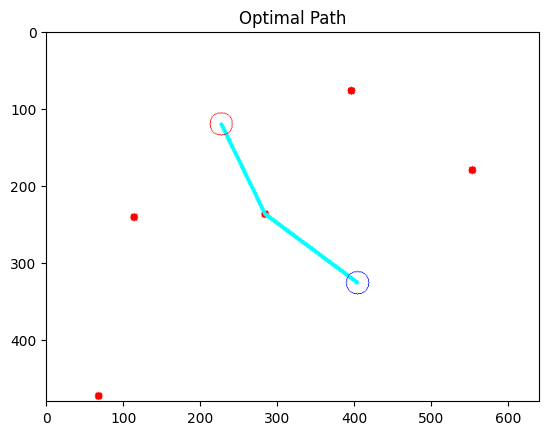

KeyboardInterrupt: 

In [33]:
window_name = 'Tracking QR Code'
camera_id = 1 # Try changing with one of these (0,1,2..) because it depends how amny cameras are connected to your PC

video_stream = cv2.VideoCapture(camera_id)
time.sleep(1)
QR_detector = cv2.QRCodeDetector()

angle_window = []  # List to store angles over a window of frames
window_size = 5  # calculate the mean over that number of frames

transformation_matrix_found = False
transformation_matrix = None
background_found = False

num_obstacles = 0
# varible is true when first time running algorithm or when kidnapped
recalculate_global = True

# Check if the webcam is opened correctly
if not video_stream.isOpened():
    raise IOError("Cannot open webcam")

while True:
    # Capture a frame from the video stream
    #print("here")
    image_detected, image = video_stream.read()
    #find_thresh(image)
    if image_detected:
        image_initial = image.copy()
        height, width, channels = image.shape
        # Apply the new percpective on the frame
        if not transformation_matrix_found:
            transformation_matrix = perspective_transformation(image)
            transformation_matrix_found = True
        if transformation_matrix_found:
            new_perspective_image = cv2.warpPerspective(image, transformation_matrix, (width, height))
        else:
            new_perspective_image = image
        if not background_found or num_obstacles != 2:
#             plt.imshow(new_perspective_image)
#             plt.title("new perspective")
#             plt.show()
            triangle_vertices, triangle_edges, goal_center = process_background(new_perspective_image)
            num_obstacles = len(triangle_vertices)
            print('vertices',triangle_vertices)
            print('edges',triangle_edges)
            print('goal',goal_center)
            background_found = True
            print('background found', background_found)
            continue

        if background_found:    
            # Detect QR codes in the captured frame
            QR_detected, points, _ = QR_detector.detectAndDecode(image_initial)

            if QR_detected: 
                points = cv2.perspectiveTransform(points.reshape(-1, 1, 2), transformation_matrix)
                points = points.reshape(1, 4, 2)

                robot_angle, robot_center = orientation_angle(points)
                #print('robot center',robot_center)
                #print(f"Individual Angle: {angle} degrees")
                angle_window.append(robot_angle)
                if len(angle_window) == window_size:
                    mean_angle = calculate_mean_angle(angle_window)
                    #G = find_shortest_path(image, robot_center)
                    #print(f"Mean Angle over {window_size} frames: {mean_angle} degrees")
                    angle_window = []  # Reset the window for the next set of frames

                #draw_vertex_circles(img_copy, points)  
                color = (0, 255, 0)
                new_perspective_image = cv2.polylines(new_perspective_image, [points.astype(int)], isClosed=True, color=color, thickness=8)
                #print(points)
                if recalculate_global:
                    shortest_path = getShortestPath(triangle_vertices, robot_center, goal_center)
                    recalculate_global = False
                    
                    # visualize the optimal path
                    Pathimage = np.zeros([height,width,3],dtype=np.uint8)
                    Pathimage.fill(255)
                    drawPathGraph(triangle_vertices, shortest_path, Pathimage)
                    plt.imshow(Pathimage)
                    plt.title("Optimal Path")
                    plt.show()
                    
                    
                    
                    
                    #new_perspective_image = cv2.polylines(new_perspective_image, polyTriangle_vertices, isClosed=True, color=color, thickness=8)
                
                # Annotating the camera feed with the optimal path and vertices of obstacles
                draw_path_on_camera(new_perspective_image, shortest_path, robot_center, robot_angle)    
                # Display the modified image in the window
                cv2.imshow(window_name, new_perspective_image)
                #G = find_shortest_path(triangle_vertices, triangle_edges, goal_center, robot_center)

    # Exiting the loop when the 'Esc' key is pressed
    c = cv2.waitKey(1)
    if c == 27:
        break

video_stream.release()
cv2.destroyAllWindows()

# Draw Path on camera feed


In [32]:
def draw_path_on_camera(cameraImage, shortestPath, robot_center, robot_angle):
    
    # drawing the expanded_vertices
    for vertices in triangle_vertices:
        for i, vertex in enumerate(vertices):
            x = vertex[0]
            y = vertex[1]
            cv2.circle(new_perspective_image, (x, y), 10, (255, 0, 0), -1) 
    
    # creating a list of edges from the list of vertices
    edgelist = []
    for i, node in enumerate(shortestPath[:-1]):
        edgelist.append((shortestPath[i], shortestPath[i + 1]))
        
    color = (0, 255, 255)
    thickness = 3
    
    # drawing the optimal path using edges
    for i, edge in enumerate(edgelist):
        #print(int(edgelist[i][0].x), int(edgelist[i][0].y))
        # if the robot is already on the path of an edge, draw from that point
        cv2.line(cameraImage, (int(edgelist[i][0].x), int(edgelist[i][0].y)), (int(edgelist[i][1].x), int(edgelist[i][1].y)), color, thickness)
        
    # drawing start and goal positions
    goal_location = shortestPath[-1]
    cv2.circle(cameraImage, (int(goal_location.x), int(goal_location.y)), 1, (255, 0, 0), -1)
    cv2.circle(cameraImage, (int(robot_center[0]), int(robot_center[1])), 5, (0, 0, 255), -1)
    
    # draw a directional arrow of robot orientation
    length = 50
    endpoint_x = int(robot_center[0] + length * np.cos(np.radians(robot_angle)))
    endpoint_y = int(robot_center[1] - length * np.sin(np.radians(robot_angle)))
    cv2.arrowedLine(cameraImage, (int(robot_center[0]), int(robot_center[1])), (endpoint_x, endpoint_y), (255, 255, 0), 2)
            